In [22]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
%matplotlib nbagg

In [32]:
df = pd.read_csv("data/kaggle_toxicity/train.csv")
df[df["identity_hate"]==1][:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1


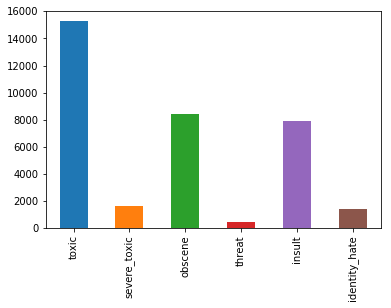

In [4]:
plt.figure()
df.sum(numeric_only=True).plot("bar")

In [5]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

## Estimate Identity hate subspace

In [26]:
stop_words = set(stopwords.words('english')) 
cols = df[df["identity_hate"]==1]
X = np.zeros((1405,300))#also get rid of bad spellings (stemming)?
for i,comment in enumerate(cols["comment_text"].items()):
    w = re.sub('[^a-z ]+', '', comment[1].lower()).split(" ")
    wf = filter(lambda x: x in embeddings and not x in stop_words,w)  
    if len(wf)>0:
        X[i,:] = np.mean(embeddings[wf],axis = 0) # get rid of stop words
X = X[np.all(X!= 0, axis=1)]

(1367, 300)

<Container object of 300 artists>

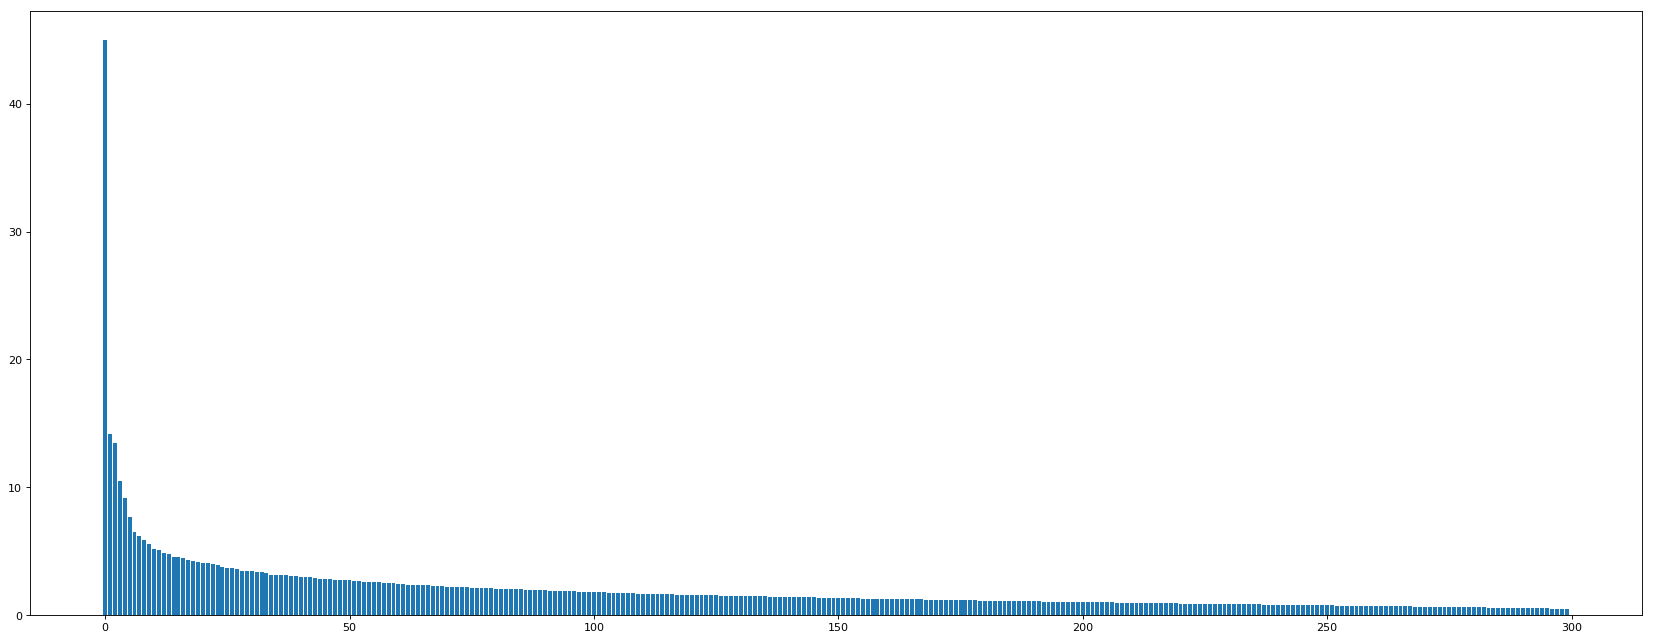

In [33]:
%matplotlib inline
u, s, vh = np.linalg.svd(X, full_matrices=True)
plt.figure(figsize=(26, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(s)),s)

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 'female', 'nonbinary', 'african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 'elderly', 'blind', 'deaf', 'paralyzed']

In [3]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [4]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [27]:
def identity_toxicity_table(embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        if word in embeddings:
            toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
            words.append(word)
    toxicities, words = zip(*sorted(zip(toxicities, words),key=lambda x : x[0]))
    return toxicities, words

In [28]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [7]:
# embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/numberbatch.txt',)
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

## train new corpus toxicity classifier

In [19]:
pos_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,pos_words))
neg_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,neg_words))
pos_vectors = embeddings_debiased[pos_words_fil_debiased]
neg_vectors = embeddings_debiased[neg_words_fil_debiased]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model_debias = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model_debias.predict(test_vectors)
(preds == test_targets).mean()

0.9682034976152624

## train debiased news corpus toxicity classifier

In [21]:
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
(preds == test_targets).mean()

0.9477020602218701

## test toxicity on gender equalized vs non equalized

In [29]:
text_to_toxicity(model_debias,embeddings_debiased,'/c/en/'+'lgbt'),text_to_toxicity(model,embeddings,"lgbt")

(0.6671733367413487, 0.9992554207924351)

## create identity keyword toxicity histograms

In [30]:
identity_toxicity_debias = identity_toxicity_table(embeddings_debiased,model_debias,add='/c/en/')
identity_toxicity = identity_toxicity_table(embeddings,model)

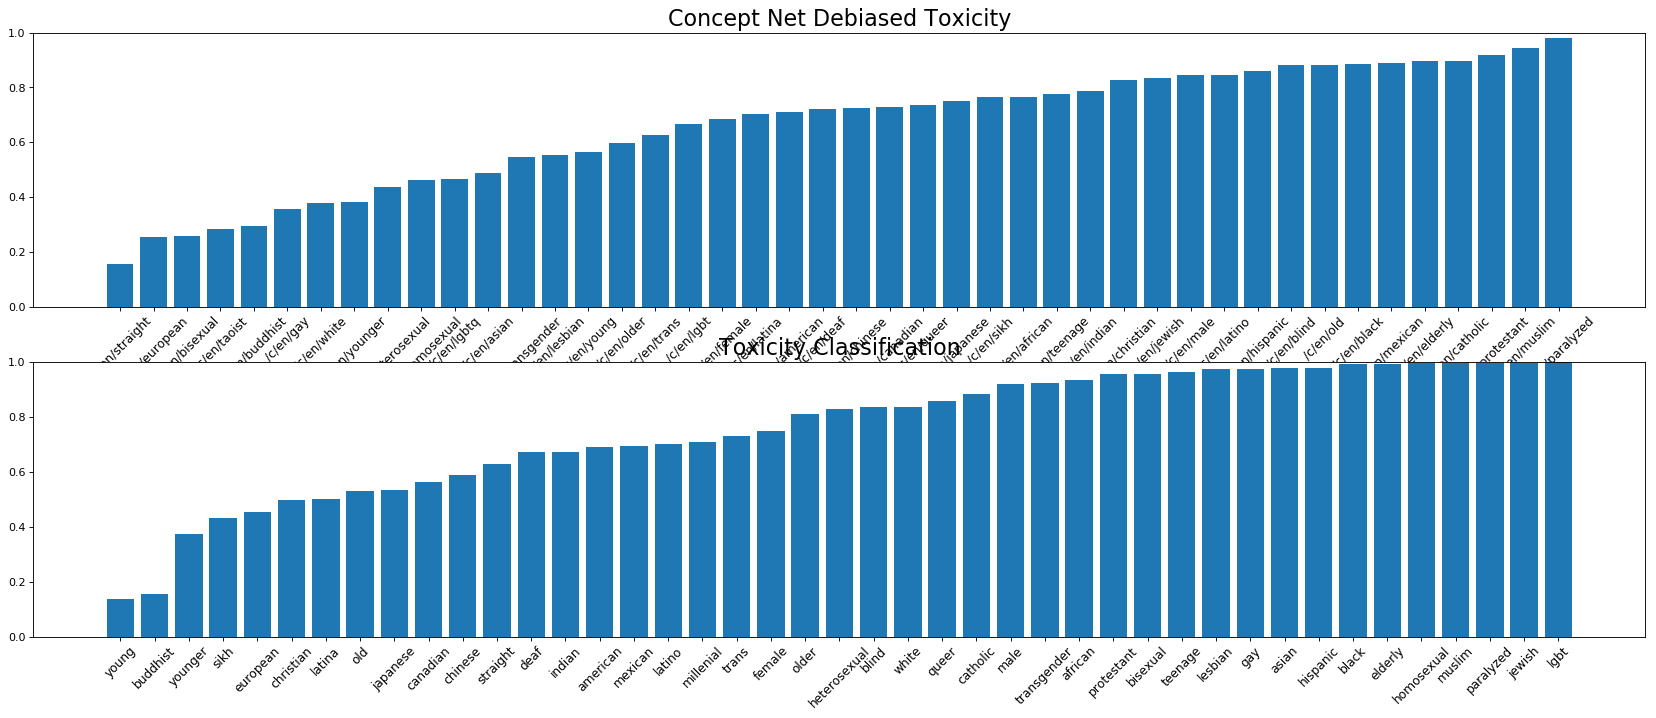

In [36]:
%matplotlib inline
f = plt.figure(figsize=(26, 10), dpi= 80, facecolor='w', edgecolor='k')
f.add_subplot(211)
plt.title("Concept Net Debiased Toxicity",fontsize=20)
index = np.arange(len(identity_toxicity_debias[1]))
plt.bar(index,identity_toxicity_debias[0])
plt.xticks(index, identity_toxicity_debias[1], fontsize=11, rotation=45)
plt.ylim(top=1,bottom=0)
f.add_subplot(212)
plt.title("Toxicity Classification",fontsize=20)
index = np.arange(len(identity_toxicity[1]))
plt.bar(index,identity_toxicity[0])
plt.xticks(index, identity_toxicity[1], fontsize=11, rotation=45)
plt.ylim(top=1,bottom=0)
plt.show()

## Toxicity Variance in histogram debiased vs non debiased

In [37]:
np.var(identity_toxicity_debias[0]),np.var(identity_toxicity[0])

(0.047957136243355535, 0.05307004741015708)

## KL Divergence from uniform dist

In [39]:
uniform_dist = np.ones(len(identity_toxicity[0]))*1./len(identity_toxicity[0])
uniform_dist_d = np.ones(len(identity_toxicity_debias[0]))*1./len(identity_toxicity_debias[0])

debiased_normalized = identity_toxicity_debias[0]/np.sum(identity_toxicity_debias[0])
biased_normalized = identity_toxicity[0]/np.sum(identity_toxicity[0])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
kl_debiased,kl_biased

(0.06231244525227525, 0.05460160202085153)